# Polarity in C. elegans via PAR proteins 

### Group 1:
#### Members: 

This project is done to explain Anterrior Posterior Symmetry Breaking in C.elegans embroys by the interplay of PAR complexes and cortical flow:

In [1]:
import sys
import os
sys.path.append('ExperimentalData/')

import numpy as np
import scipy as sc
import pickle
import dill
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
dill.dump_session('data/projectPolarity')

In [3]:
dill.load_session('data/projectPolarity')

### Experimental Data

In [2]:
with open('ExperimentalData/T_PARs.txt','r') as T_PARs:
    time_pars = np.loadtxt(T_PARs)
T_PARs.close()
    
with open('ExperimentalData/X_PARs.txt','r') as X_PARs:
    x_pars = np.loadtxt(X_PARs)
X_PARs.close()

with open('ExperimentalData/PAR6.txt','r') as A_PARs:
    a_pars = np.loadtxt(A_PARs)
A_PARs.close()

with open('ExperimentalData/PAR2.txt','r') as P_PARs:
    p_pars = np.loadtxt(P_PARs)
P_PARs.close()

with open('ExperimentalData/X_flow.txt','r') as X_flow:
    x_flow = np.loadtxt(X_flow)
X_flow.close()
    
with open('ExperimentalData/T_flow.txt','r') as T_flow:
    t_flow = np.loadtxt(T_flow)
T_flow.close()

with open('ExperimentalData/Flow.txt','r') as F_flow:
    f_flow = np.loadtxt(F_flow)
F_flow.close()

#with open("FLOW_INTERP_4077.mat",'r') as int_flow:
    #interp_flow = np.load(int_flow)

from scipy.io import loadmat
interp_mat = loadmat("finalflow.mat")['FF_interp']

In [3]:
V_cyto = 2.5*10**4
S_mem = 4.4*10**3
D_a = 0.28
D_p = 0.15
k_offa = 3.24*10**-3
k_offp = 7.19*10**-3
k_ona = 6.29*10**-3
k_onp = 7.682*10**-2
alpha = 2.
beta = 2.
N_a = 2.4*10**5
N_p = 9.8*10**4

### Plotting Experimental data

Text(0.5,1,u'P_PAR')

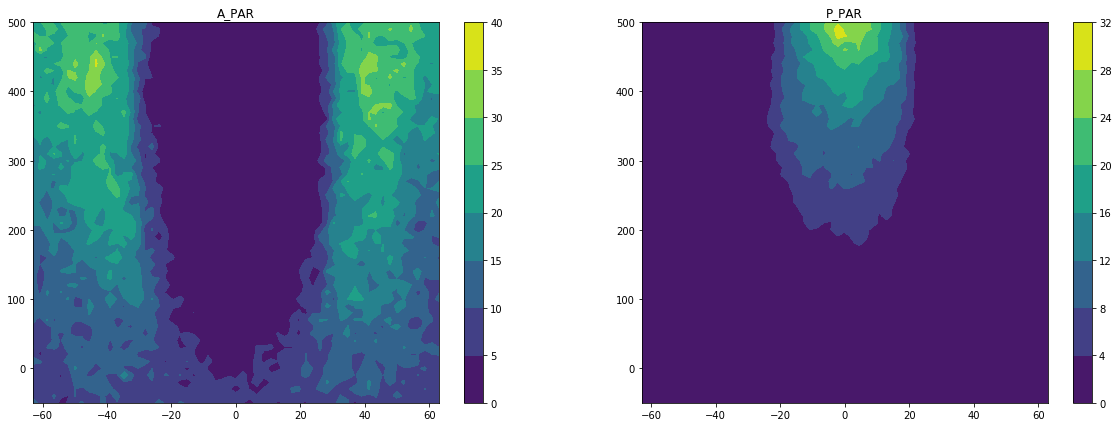

In [4]:
plt.figure(figsize=(20,7))
plt.subplot(121)
plt.contourf(x_pars,time_pars,a_pars)
plt.colorbar()
plt.title('A_PAR')

plt.subplot(122)
plt.contourf(x_pars,time_pars,p_pars)
plt.colorbar()
plt.title('P_PAR')

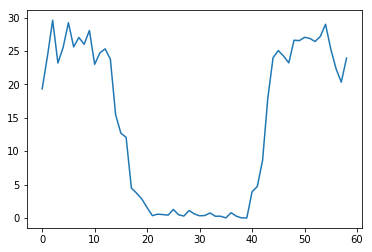

In [5]:
plt.plot(a_pars[-1,:])

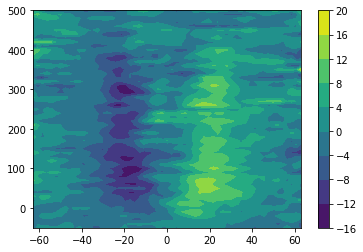

In [6]:
plt.contourf(x_flow,t_flow,f_flow)
plt.colorbar()

In [7]:
a_pars_cyto = (np.ones(np.shape(a_pars))*N_a - a_pars*S_mem)/V_cyto
p_pars_cyto = (np.ones(np.shape(p_pars))*N_p - p_pars*S_mem)/V_cyto

a_pars_pm_total = np.sum(a_pars,axis=1)*S_mem
p_pars_pm_total = np.sum(p_pars,axis=1)*S_mem
a_pars_cyto_total = np.sum(a_pars_cyto,axis=1)*V_cyto
p_pars_cyto_total = np.sum(p_pars_cyto,axis=1)*V_cyto

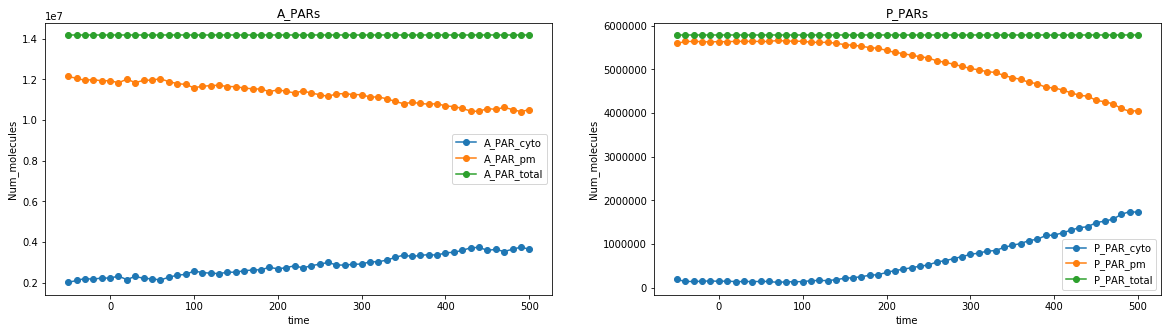

In [8]:
plt.figure(figsize=(20,5))

plt.subplot(121)
plt.plot(time_pars,a_pars_pm_total,'o-')
plt.plot(time_pars,a_pars_cyto_total,'o-')
plt.plot(time_pars,a_pars_pm_total+a_pars_cyto_total,'o-')
plt.title('A_PARs')
plt.ylabel('Num_molecules')
plt.xlabel('time')
plt.legend(['A_PAR_cyto','A_PAR_pm','A_PAR_total'])

plt.subplot(122)
plt.plot(time_pars,p_pars_pm_total,'o-')
plt.plot(time_pars,p_pars_cyto_total,'o-')
plt.plot(time_pars,p_pars_pm_total+p_pars_cyto_total,'o-')
plt.title('P_PARs')
plt.ylabel('Num_molecules')
plt.xlabel('time')
plt.legend(['P_PAR_cyto','P_PAR_pm','P_PAR_total'])

## System of equations:

$$ \frac{\partial A(x,t)}{\partial t} = -k_{offA}'A - K_{AP}A(x,t)P^{\alpha}(x,t) + {k_{onA}N_A/V_{cyto}} + D_A\frac{\partial^2 A(x,t)}{\partial x^2} - \frac{\partial}{\partial x} \left( A(x,t)v(x,t) \right)$$

$$ \frac{\partial P(x,t)}{\partial t} = -k_{offP}'P - K_{PA}P(x,t)A^{\beta}(x,t) + {k_{onP}N_P/V_{cyto}} + D_P\frac{\partial^2 P(x,t)}{\partial x^2} - \frac{\partial}{\partial x}\left(P(x,t)v(x,t)\right) $$

where $$ k_{offA}' = k_{offA} + \frac{k_{onA}\omega_{membrane}}{V_{cyto}} $$

$$ k_{offP}' = k_{offP} + \frac{k_{onP}\omega_{membrane}}{V_{cyto}} $$


### The system:

In [12]:
## Determining the time step:

t_delta = abs(np.round(0.05*2*((x_pars - np.roll(x_pars,1))[1])/(np.max(abs(f_flow))),10))
x_delta = (x_pars - np.roll(x_pars,1))[1]

total_pos = len(x_pars)
int_time  = np.int(np.ceil((time_pars[-1]-time_pars[0])/t_delta))

#Parameters:
par = [k_offa + k_ona*S_mem/V_cyto, k_offp + k_onp*S_mem/V_cyto, k_ona*N_a/V_cyto, k_onp*N_p/V_cyto, 2,2, D_a,D_p]

#Initial Conditions:
x0 = np.zeros([2,len(x_pars)])
x0[0,:] = a_pars[0,:]
x0[1,:] = p_pars[0,:]

# Interploating velocities:

v_interp = np.zeros([int_time,len(x_pars)])
for i in np.arange(len(x_pars)):
    interp_fun = sc.interpolate.interp1d(time_pars,f_flow[:,i],kind=5)
    v_interp[:,i] = interp_fun(np.arange(time_pars[0],time_pars[-1],int_time))
    del interp_fun

In [82]:
def diff(t_delta,x_delta,init_time,total_pos,D_A):
    
    A = np.zeros([total_pos,int_time])
    A[10:20,0] = 1
    
    for i in np.arange(int_time-1):

        A[:,i+1] = A[:,i] + t_delta*(D_A*(np.roll(A[:,i],-1) - 2*A[:,i] + np.roll(A[:,i],1))/(2*x_delta**2))
        
    return A

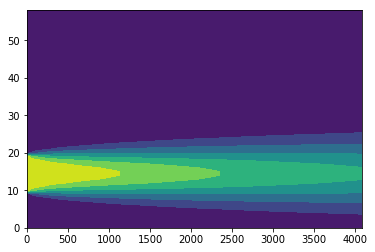

In [15]:
a = diff(t_delta,x_delta,int_time,total_pos,D_a)

plt.contourf(a)

In [308]:
def systemsolve(x0,v,t_delta,x_delta,total_pos,int_time,parametrs):
    
    k_offA = parametrs[0]
    k_offP = parametrs[1]
    c1     = parametrs[2]
    c2     = parametrs[3]
    alpha  = parametrs[4]
    beta   = parametrs[5]
    D_A    = parametrs[6]
    D_P    = parametrs[7]
    
    
    def fitsolver(x,*p):
        
        A = np.zeros([total_pos,int_time])
        A[:,0] = x0[0,:]
        P = np.zeros([total_pos,int_time])
        P[:,0] = x0[1,:]

        K_AP   = p[0]
        K_PA   = p[1]

        for i in np.arange(int_time-1):

            A[:,i+1] = #A[:,i] + t_delta*(-k_offA*A[:,i] - K_AP*A[:,i]*P[:,i]**alpha + c1 - \
                       A[:,i]*(np.roll(v[:,i],-1) - np.roll(v[:,i],1))/(2*x_delta) - \
                       v[:,i]*(np.roll(A[:,i],-1) - np.roll(A[:,i],1))/(2*(x_delta)) + \
                       D_A*(np.roll(A[:,i],-1) - 2*A[:,i] + np.roll(A[:,i],1))/(2*x_delta**2))

            P[:,i+1] = #P[:,i] + t_delta*(-k_offP*P[:,i] - K_PA*P[:,i]*A[:,i]**beta + c2 - \
                       P[:,i]*(np.roll(v[:,i],-1) - np.roll(v[:,i],1))/(2*x_delta) - \
                       v[:,i]*(np.roll(P[:,i],-1) - np.roll(P[:,i],1))/(2*(x_delta)) + \
                       D_P*(np.roll(P[:,i],-1) - 2*P[:,i] + np.roll(P[:,i],1))/(2*x_delta**2))
            
        total = np.zeros(2*len(x))

        total[0:len(x)] = np.interp(x,np.arange(x[0],x[-1],t_delta),np.sum(A,axis=0))            

        total[len(x)-1:-1] = np.interp(x,np.arange(x[0],x[-1],t_delta),np.sum(P,axis=0))

        return total
        
    return fitsolver

In [171]:
from scipy.optimize import curve_fit

popt,pcov = curve_fit(systemsolve(x0,v_interp.T,t_delta,x_delta,total_pos,int_time,par),time_pars,np.append(a_pars_pm_total,p_pars_pm_total)/S_mem,[0.0001,0.0001])

print popt

/home/moshir/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in multiply
/home/moshir/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in multiply
/home/moshir/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in subtract
/home/moshir/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in add
/home/moshir/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in subtract
/home/moshir/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in add


[ 0.0001  0.0001]


In [20]:
def systemsolve_lq(p,x0,v,t_delta,x_delta,total_pos,int_time,parametrs,x,soln):
    
    k_offA = parametrs[0]
    k_offP = parametrs[1]
    c1     = parametrs[2]
    c2     = parametrs[3]
    alpha  = parametrs[4]
    beta   = parametrs[5]
    D_A    = parametrs[6]
    D_P    = parametrs[7]
    
    A = np.zeros([total_pos,int_time])
    A[:,0] = smooth(x0[0,:],5)[0:-4]
    P = np.zeros([total_pos,int_time])
    P[:,0] = smooth(x0[1,:],5)[0:-4]
    
    K_AP   = p[0]
    K_PA   = p[1]
    
    #print parametrs,total_pos,int_time,K_AP,K_PA,t_delta,x_delta
    
    for i in np.arange(int_time-1):
        
        #print np.mean(A[:,i])
        
        A[:,i+1] = A[:,i] + t_delta*(-k_offA*A[:,i] - K_AP*A[:,i]*P[:,i]**alpha + c1 - \
                  #A[:,i]*(np.roll(v[:,i],-1) - np.roll(v[:,i],1))/(2*x_delta) - \
                 v[:,i]*(np.roll(A[:,i],-1) - np.roll(A[:,i],1))/(2*x_delta) + \
                 (D_A)*(np.roll(A[:,i],-1) - 2*A[:,i] + np.roll(A[:,i],1))/(x_delta**2))

        P[:,i+1] = P[:,i] + t_delta*(-k_offP*P[:,i] - K_PA*P[:,i]*A[:,i]**beta + c2 - \
                   #P[:,i]*(np.roll(v[:,i],-1) - np.roll(v[:,i],1))/(2*x_delta) - \
                   v[:,i]*(np.roll(P[:,i],-1) - np.roll(P[:,i],1))/(2*x_delta) + \
                   (D_P)*(np.roll(P[:,i],-1) - 2*P[:,i] + np.roll(P[:,i],1))/(x_delta**2))

        #A[:,i+1] = A[:,i] + t_delta*(-k_offA*A[:,i] -K_AP*A[:,i]*P[:,i]**alpha + c1 -  \
         #          A[:,i]*(np.roll(v[:,i],-1) - np.roll(v[:,i],1))/(2*x_delta) - \
       #            (v[:,i]+abs(v[:,i]))*(-np.roll(A[:,i],1) + np.roll(A[:,i],0))/(2*x_delta) - \
        #           (v[:,i]-abs(v[:,i]))*(np.roll(A[:,i],-1) - np.roll(A[:,i],0))/(2*x_delta) +
         #          (D_A)*(np.roll(A[:,i],-1) - 2*A[:,i] + np.roll(A[:,i],1))/(x_delta**2))

       # P[:,i+1] = P[:,i] + t_delta*(-k_offP*P[:,i] - K_PA*P[:,i]*A[:,i]**beta + c2 -  \
        #           P[:,i]*(np.roll(v[:,i],-1) - np.roll(v[:,i],1))/(2*x_delta) - \
        #           (v[:,i]+abs(v[:,i]))*(-np.roll(P[:,i],1) + np.roll(P[:,i],0))/(2*x_delta) - \
        #          (v[:,i]-abs(v[:,i]))*(np.roll(P[:,i],-1) - np.roll(P[:,i],0))/(2*x_delta) +
         #         (D_P)*(np.roll(P[:,i],-1) - 2*P[:,i] + np.roll(P[:,i],1))/(x_delta**2))
        
        for j in np.arange(total_pos):
            if A[j,i+1]<0:
                A[j,i+1] =0
            if P[j,i+1]<0:
                P[j,i+1]=0
    
    total = np.zeros(2*total_pos)

    total[0:total_pos] = A[:,-1]

    total[total_pos-1:-1] = P[:,-1]
    
    return total-soln

In [31]:
from scipy.optimize import least_squares

soln_lq = least_squares(systemsolve_lq,[10**-3,10**-4],bounds=[[0,0],[1,1]],\
        args=(x0,interp_mat.T,t_delta,x_delta,total_pos,int_time,par,time_pars,np.append(a_pars[-1,:],p_pars[-1,:])),method='dogbox')

print soln_lq

 active_mask: array([-1,  0])
        cost: 6793.4287905303054
         fun: array([ -5.91653941, -10.76343941, -16.18483941,  -9.78003942,
       -12.13103942, -15.81863943, -12.19503945, -13.61023949,
       -12.57413938, -14.65333917,  -9.58253921, -11.2936392 ,
       -11.90113919, -10.33773921,  -2.00943919,   0.7239608 ,
         1.3515608 ,   8.9420908 ,   9.7066308 ,  10.5983108 ,
        11.8775608 ,  13.0756428 ,  12.8560338 ,  12.9138968 ,
        12.9989908 ,  12.1407108 ,  12.9444788 ,  13.1369078 ,
        12.3109708 ,  12.8153048 ,  13.0995228 ,  13.0580928 ,
        12.6689978 ,  13.1638318 ,  13.1601658 ,  13.41545689,
        12.6358188 ,  13.1578958 ,  13.41545631,  13.41545664,
         9.5024908 ,   8.70229079,   4.79625079,  -4.53073922,
       -10.57463923, -11.64073925, -10.81983926,  -9.80213928,
       -13.19343931, -13.12953934, -13.63153936, -13.46453937,
       -12.99673938, -13.75963938, -15.58353938, -11.86313938,
        -8.93893939,  -6.91063939, -16.90

In [24]:
def systemsolve_lq2(p,x0,v,t_delta,x_delta,total_pos,int_time,parametrs,x,soln):
    
    k_offA = parametrs[0]
    k_offP = parametrs[1]
    c1     = parametrs[2]
    c2     = parametrs[3]
    alpha  = parametrs[4]
    beta   = parametrs[5]
    D_A    = parametrs[6]
    D_P    = parametrs[7]
    
    A = np.zeros([total_pos,int_time])
    A[:,0] = smooth(x0[0,:],5)[0:-4]
    P = np.zeros([total_pos,int_time])
    P[:,0] = smooth(x0[1,:],5)[0:-4]
    
    K_AP   = p[0]
    K_PA   = p[1]
    
    #print parametrs,total_pos,int_time,K_AP,K_PA,t_delta,x_delta
    
    for i in np.arange(int_time-1):
        
        #print np.mean(A[:,i])
        
        A[:,i+1] = A[:,i] + t_delta*(-k_offA*A[:,i] - K_AP*A[:,i]*P[:,i]**alpha + c1 - \
                  #A[:,i]*(np.roll(v[:,i],-1) - np.roll(v[:,i],1))/(2*x_delta) - \
                 v[:,i]*(np.roll(A[:,i],-1) - np.roll(A[:,i],1))/(2*x_delta) + \
                  (D_A)*(np.roll(A[:,i],-1) - 2*A[:,i] + np.roll(A[:,i],1))/(x_delta**2))

        P[:,i+1] = P[:,i] + t_delta*(-k_offP*P[:,i] - K_PA*P[:,i]*A[:,i]**beta + c2 - \
                   #P[:,i]*(np.roll(v[:,i],-1) - np.roll(v[:,i],1))/(2*x_delta) - \
                   v[:,i]*(np.roll(P[:,i],-1) - np.roll(P[:,i],1))/(2*x_delta) + \
                   (D_P)*(np.roll(P[:,i],-1) - 2*P[:,i] + np.roll(P[:,i],1))/(x_delta**2))
        
        #A[:,i+1] = 0.5*(np.roll(A[:,i],1)+np.roll(A[:,i],-1)) + t_delta*(-k_offA*A[:,i] -K_AP*A[:,i]*P[:,i]**alpha + c1 -  \
         #          #A[:,i]*(np.roll(v[:,i],-1) - np.roll(v[:,i],1))/(2*x_delta) - \
         #          (v[:,i]+abs(v[:,i]))*(-np.roll(A[:,i],1) + np.roll(A[:,i],0))/(2*x_delta) - \
         #         (v[:,i]-abs(v[:,i]))*(np.roll(A[:,i],-1) - np.roll(A[:,i],0))/(2*x_delta) +
         #        (D_A)*(np.roll(A[:,i],-1) - 2*A[:,i] + np.roll(A[:,i],1))/(x_delta**2))

        #P[:,i+1] = 0.5*(np.roll(P[:,i],1)+np.roll(P[:,i],-1)) + t_delta*(-k_offP*P[:,i] - K_PA*P[:,i]*A[:,i]**beta + c2 -  \
                     #P[:,i]*(np.roll(v[:,i],-1) - np.roll(v[:,i],1))/(2*x_delta) - \
          #           (v[:,i]+abs(v[:,i]))*(-np.roll(P[:,i],1) + np.roll(P[:,i],0))/(2*x_delta) - \
          #           (v[:,i]-abs(v[:,i]))*(np.roll(P[:,i],-1) - np.roll(P[:,i],0))/(2*x_delta) +
        #             (D_P)*(np.roll(P[:,i],-1) - 2*P[:,i] + np.roll(P[:,i],1))/(x_delta**2))
        
        for j in np.arange(total_pos):
            if A[j,i+1]<0:
                A[j,i+1] =0
            if P[j,i+1]<0:
                P[j,i+1]=0
        
    
    total = np.zeros(2*total_pos)

    total[0:total_pos] = A[:,-1]

    total[total_pos-1:-1] = P[:,-1]
    
    return total,A,P

In [32]:
print soln_lq.x[0],soln_lq.x[1]

0.0 0.000124047418535


In [33]:
soln,A,P = systemsolve_lq2([soln_lq.x[0],soln_lq.x[1]],x0,interp_mat.T,t_delta,\
                           x_delta,total_pos,int_time,par,time_pars,np.append(a_pars[-1,:],p_pars[-1,:]))

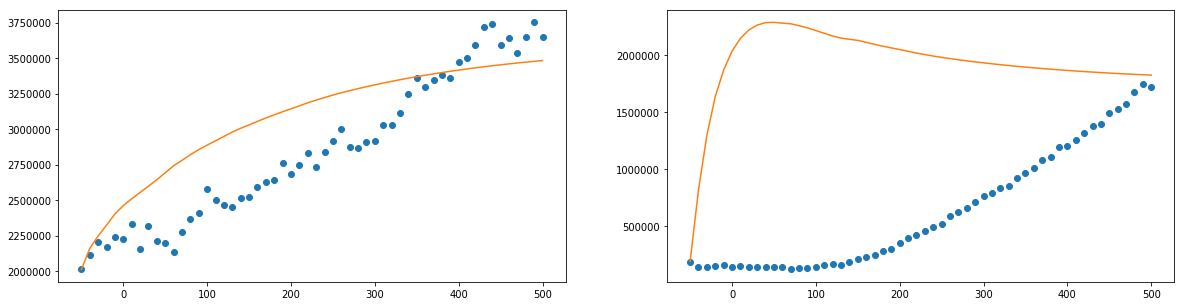

In [34]:
plt.figure(figsize=(20,5))

plt.subplot(121)
plt.plot(time_pars,a_pars_pm_total,'o')
plt.plot(time_pars,np.interp(time_pars,np.arange(time_pars[0],time_pars[-1],t_delta),np.sum(A,axis=0))*S_mem)

plt.subplot(122)
plt.plot(time_pars,p_pars_pm_total,'o')
plt.plot(time_pars,np.interp(time_pars,np.arange(time_pars[0],time_pars[-1],t_delta),np.sum(P,axis=0))*S_mem)
#plt.xlim([0,40])
#plt.ylim([0,1000])

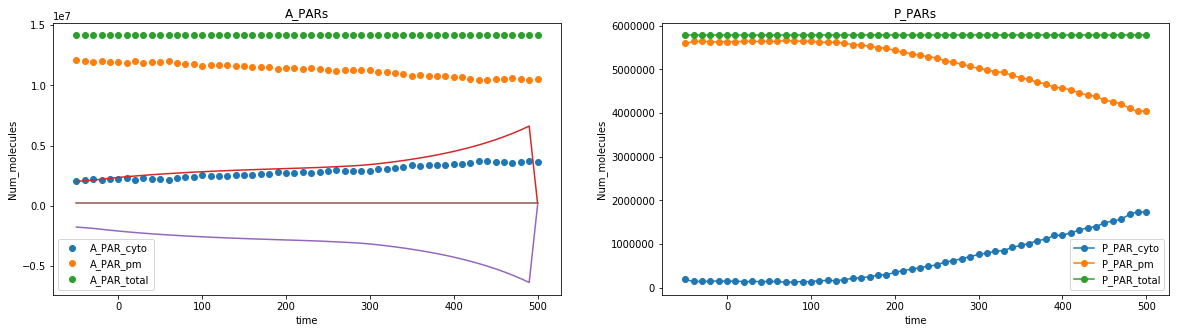

In [216]:
plt.figure(figsize=(20,5))

plt.subplot(121)
plt.plot(time_pars,a_pars_pm_total,'o')
plt.plot(time_pars,a_pars_cyto_total,'o')
plt.plot(time_pars,a_pars_pm_total+a_pars_cyto_total,'o')

plt.plot(time_pars,soln[0:len(time_pars)]*S_mem)
plt.plot(time_pars,(N_a - soln[0:len(time_pars)]*S_mem))
plt.plot(time_pars,(N_a - soln[0:len(time_pars)]*S_mem + soln[0:len(time_pars)]*S_mem))

plt.title('A_PARs')
plt.ylabel('Num_molecules')
plt.xlabel('time')
plt.legend(['A_PAR_cyto','A_PAR_pm','A_PAR_total'])

plt.subplot(122)
plt.plot(time_pars,p_pars_pm_total,'o-')
plt.plot(time_pars,p_pars_cyto_total,'o-')
plt.plot(time_pars,p_pars_pm_total+p_pars_cyto_total,'o-')
plt.title('P_PARs')
plt.ylabel('Num_molecules')
plt.xlabel('time')
plt.legend(['P_PAR_cyto','P_PAR_pm','P_PAR_total'])

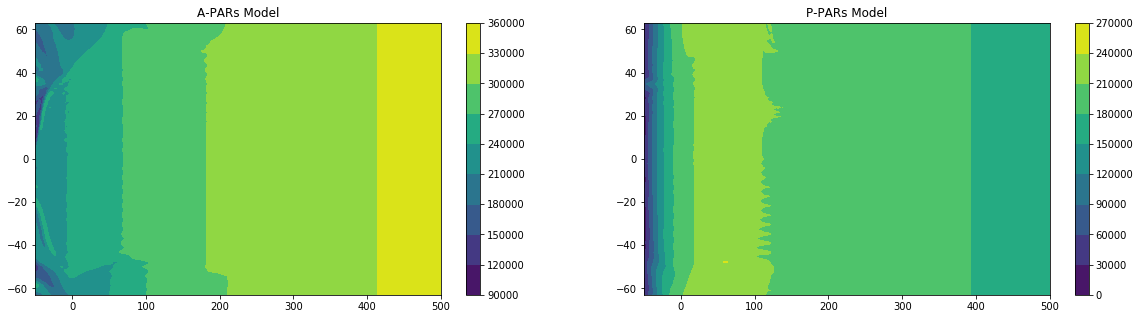

In [27]:
plt.figure(figsize=(20,5))

plt.subplot(121)
plt.contourf(np.arange(time_pars[0],time_pars[-1],t_delta),x_pars,A*V_cyto)
plt.title('A-PARs Model')
plt.colorbar()

plt.subplot(122)
plt.contourf(np.arange(time_pars[0],time_pars[-1],t_delta),x_pars,P*V_cyto)
plt.title('P-PARs Model')
plt.colorbar()

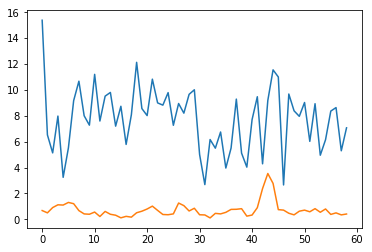

In [225]:
plt.plot(x0[0])
plt.plot(x0[1])

/home/moshir/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:80: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/home/moshir/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/home/moshir/anaconda2/lib/python2.7/site-packages/matplotlib/rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


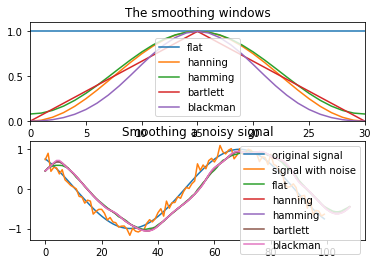

In [15]:
import numpy

def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError, "smooth only accepts 1 dimension arrays."

    if x.size < window_len:
        raise ValueError, "Input vector needs to be bigger than window size."


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"


    s=numpy.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y




from numpy import *
from pylab import *

def smooth_demo():

    t=linspace(-4,4,100)
    x=sin(t)
    xn=x+randn(len(t))*0.1
    y=smooth(x)

    ws=31

    subplot(211)
    plot(ones(ws))

    windows=['flat', 'hanning', 'hamming', 'bartlett', 'blackman']

    hold(True)
    for w in windows[1:]:
        eval('plot('+w+'(ws) )')

    axis([0,30,0,1.1])

    legend(windows)
    title("The smoothing windows")
    subplot(212)
    plot(x)
    plot(xn)
    for w in windows:
        plot(smooth(xn,10,w))
    l=['original signal', 'signal with noise']
    l.extend(windows)

    legend(l)
    title("Smoothing a noisy signal")
    show()


if __name__=='__main__':
    smooth_demo()

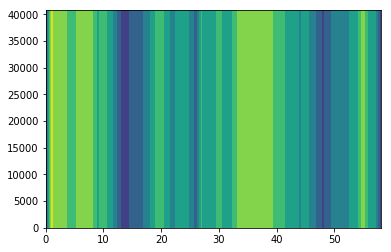

In [145]:
plt.contourf(v_interp)

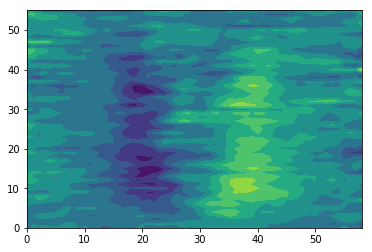

In [59]:
plt.contourf(f_flow)

In [213]:
np.shape(v_interp)

(40766, 59)

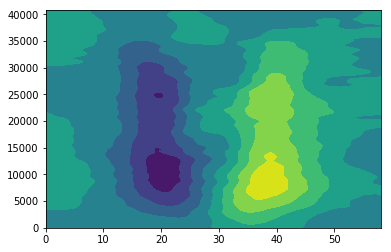

In [230]:
plt.contourf(interp_mat)

$$ A_{x_n}^{t_{n+1}} = \frac{(A_{x_{n-1}}+ A_{x_{n+1}}^{t_n})}{2} + \delta_t(-k_{offA}'A_{x_n}^{t_n} -K_{AP}A_{x_n}^{t_n}(P_{x_n}^{t_n})^2 + c_1 - (v+|v|)\frac{A_{x_n}^{t_n} - A_{x_{n-1}}^{t_n}}{2\delta_x} - (v - |v|)\frac{A_{x_{n+1}}^{t_n} - A_{x_n}^{t_n}}{2\delta_x} + D_A(\frac{A_{x_{n+1}}^{t_n} -2A_{x_n}^{t_n} + A_{x_{n-1}}^{t_n} }{\delta_x^2}) $$

$$  $$